In [1]:
import numpy as np
import scipy as sy
import pandas as pd

import time
import sys
import os
import ast
import json
import copy 
import itertools

from itertools import islice
from tqdm import *
from math import ceil
from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.sparse import csr_matrix, dok_matrix
from ipynb.fs.full.Random_Sample_Mapper import *

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Read In Data

In [2]:
notebook_path = os.path.abspath("BPR_OPT_Binary_Model.ipynb")
users_items_file_path = os.path.join(os.path.dirname(notebook_path), "data/australian_users_items.json")
items_file_path = os.path.join(os.path.dirname(notebook_path), "data/items_meta_data.json")
users_meta_data_file_path = os.path.join(os.path.dirname(notebook_path), "data/users_meta_data.json")

In [3]:
users_items = []
with open(users_items_file_path, 'r') as data:
    for line in data:
        users_items.append(ast.literal_eval(line))

In [4]:
with open(items_file_path, 'r') as data:
    games_dict = json.load(data)

In [5]:
with open(users_meta_data_file_path, 'r') as file:
    users_meta_data = json.load(file)

# Process Data into Training and Testing Sets

Using default dict for efficient data retrieval for users-items playtime relationship

In [6]:
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
playtimesPerItem = defaultdict(dict)
playtimesPerUser = defaultdict(dict)
itemNames = defaultdict(str)

In [7]:
for game in games_dict:
    if 'owners' in games_dict[game]:
        usersPerItem[game] = set(games_dict[game]['owners'].keys())

In [8]:
for user in users_items:
    u_id = user['user_id']
    items = [item['item_id'] for item in user['items']]
    itemsPerUser[u_id] = items
    playtimesPerUser[user['user_id']] = dict((item['item_id'], item['playtime_forever']) for item in user['items'])
    for item in user['items']:
        itemNames[item['item_id']] = item['item_name']
        playtimesPerItem[item['item_id']][user['user_id']] = item['playtime_forever']

## Scheduled Sampling with Map-Reduce Algorithm

In [9]:
nUsers = len(itemsPerUser)
nItems = len(usersPerItem)
users = list(itemsPerUser.keys())
items = list(usersPerItem.keys())

In [10]:
user_item_counts = dict((k, len(v)) for k, v in itemsPerUser.items())

In [11]:
datafile = 'data/sample_in.tsv'
mapout1 = 'data/sample_map1.tsv'
mapout2 = 'data/sample_map2.tsv'
outfile = 'data/sample_out.tsv'

f = open(datafile,'w')
for u, its in itemsPerUser.items():
    for i in its:
        print(default_formatter(u,i), file=f)
f.close()

In [12]:
# run two stages of mapreduce
mapper = Mapper(user_item_counts)
mapreduce(datafile, mapout1, mapper=mapper, reducer=reducer)
mapreduce(datafile, mapout2, mapper=indicator_mapper)  # map the data again
mapreduce([mapout1, mapout2], outfile, reducer=indicator_reducer)

In [13]:
def trim(u, i, j):
    return u[1:len(u)-1], i[2:len(i)-2], j[1:len(j)-2]

In [14]:
def create_data(filepath):
    f = open(filepath)
    samples = [map(str, line.strip().split()) for line in f]
    return [trim(u, i, j) for u, i, j in samples]

In [15]:
def create_random_batches(data, batch_size=1024):
    batches = []
    random.shuffle(data)
    num_batches = int(len(data)/batch_size)
    for i in range(num_batches):
        mini_batch = data[i*batch_size:(i+1)*batch_size]
        batches.append(mini_batch)
    return batches

In [16]:
data = create_data(outfile)

In [17]:
sample_data = train_test_split(data, train_size=0.05)[0]

/home/arnold/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
sampleUsersPerItem = defaultdict(set)
sampleItemsPerUser = defaultdict(set)

In [19]:
for u, i, j in sample_data:
    sampleUsersPerItem[i].add(u)
    sampleItemsPerUser[u].add(i)

In [20]:
train_data = sample_data
sampleItems = list(sampleUsersPerItem.keys())
sampleUsers = list(sampleItemsPerUser.keys())

In [21]:
test_data = []
for u in sampleItemsPerUser:
    for i in sampleItemsPerUser[u]:
        j = random.choice(sampleItems)
        test_data.append((u, i, j))

# Utility Functions

In [22]:
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

In [23]:
def graph(data, title):
    plt.plot([x for x in range(len(data))], data, linewidth=2.0)
    plt.title(title)
    plt.show()

In [24]:
def binary_label(u, i, j):
    c = Counter(itemsPerUser[u])
    if c[i] >= c[j]:
        return 1
    else:
        return 0

In [25]:
def generate_outputs(sample, binary):
    predictions = []
    labels = []
    for u, i, j in sample:
        predict = sigmoid(prediction(u, i, j))
        label = binary(u, i, j)
        predictions.append(predict)
        labels.append(label)
            
    return np.rint(predictions), labels

In [26]:
def accuracy(predictions, labels):
    differences = [1 if x == y else 0 for x, y in zip(predictions, labels)]
    return sum(differences) / len(differences)

In [27]:
train_labels = [binary_label(u, i, j) for u, i, j in train_data]

## Sigmoid Function

\begin{equation*}
\sigma(x) = \frac{1}{1 + e^{-x}}
\end{equation*}

In [41]:
def sigmoid(x):
    #Numerically stable sigmoid function.
    #Taken from: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
        z = np.exp(x)
        return z / (1 + z)

# Simple (Bias Only) Latent Factor Model with Binary Classification

In [ ]:
loss_history = []
train_accuracy_history = []

In [42]:
itemBiases = defaultdict(float)

In [43]:
def unpack(theta):
    global itemBiases
    itemBiases = dict(zip(items, theta))

## Prediction Function

\begin{equation*}
f(i, j) = \beta_i - \beta_j
\end{equation*}

\begin{equation*}
p(i >_u j) = \sigma(f(i, j))
\end{equation*}

In [44]:
def prediction(u, item_i, item_j):
    return itemBiases[item_i] - itemBiases[item_j]

\begin{equation*}
\text{Cost Function (arg min)}:= \sum_{u,i,j} -\ln(\sigma(\beta_i - \beta_j)) + \lambda \sum_i \beta_i^2 = \sum_{u,i,j} -ln\left( \frac{1}{1 + e^{\beta_j - \beta_i}} \right) + \lambda \sum_i \beta_i^2
\end{equation*}

## Cost Function

In [45]:
def cost(theta, lamb, train_data, train_labels):
    unpack(theta)
    cost = 0.0
    predictions = []
    for u, i, j in train_data:
        x = prediction(u, i, j)
        predictions.append(sigmoid(x))
        cost += np.log(sigmoid(x))

    for i in itemBiases:
        cost -= lamb*itemBiases[i]**2

    train_accuracy = accuracy(np.rint(predictions), train_labels)
    loss_history.append(-cost)
    train_accuracy_history.append(train_accuracy)
    #print('iteration {0} Cost: {1}'.format(len(loss_history), -cost))
    #print('iteration {0} Training Accuracy: {1}'.format(len(train_accuracy_history), train_accuracy))
    #print('-------------------------------------------------------------------')

    return -cost

\begin{equation*}
\frac{\partial }{\partial x} ln\sigma(x) = \frac{1}{1 + e^x} = \sigma(-x)
\end{equation*}

## Partial Derivatives

\begin{equation*}
\frac{\partial f}{\partial \beta_i} = -\frac{e^{\beta_j - \beta_i}}{1 + e^{\beta_j - \beta_i}} + 2 \lambda \beta_j = -\frac{1}{1 + e^{\beta_i - \beta_j}} + 2 \lambda \beta_j
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_j} = \frac{e^{\beta_j - \beta_i}}{1 + e^{\beta_j - \beta_i}} + 2 \lambda \beta_j = \frac{1}{1 + e^{\beta_i - \beta_j}} + 2 \lambda \beta_j
\end{equation*}

### [Important]: switch the sign of all partial derivatives to compute your gradient ascent

In [46]:
def derivative(theta, lamb, train_data, train_labels):
    unpack(theta)
    dItemBiases = defaultdict(float)
    for u, i, j in train_data:
        x = prediction(u, i, j)
        dbase = 1 / (1 + np.exp(x)) # negative gradient descent for maximizing
        dItemBiases[i] += -dbase
        dItemBiases[j] += dbase
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dItemBiases[i] for i in items]
    return np.array(dtheta)

In [ ]:
d

In [ ]:
unpack(res)

In [ ]:
plt.plot([x for x in range(len(loss_history))], loss_history, linewidth=2.0)
plt.title('Bias Only Loss History')
plt.show()

In [ ]:
plt.plot([x for x in range(len(train_accuracy_history))], train_accuracy_history, linewidth=2.0)
plt.title('Bias Only Training Accuracy History')
plt.show()

In [ ]:
predictions, labels = generate_outputs(test_data, binary_label)

In [ ]:
accuracy(predictions, labels)

In [ ]:
np.save('./data/bias_only_itemBiases', itemBiases)
np.save('./data/bias_only_loss', loss_history)
np.save('./data/bias_only_train_accuracy', train_accuracy_history)

# Complete Latent Factor Model with Binary Classification

This code extends the example above to implement a complete latent factor model (i.e., including low-dimensional user and item terms).

In [ ]:
loss_history = []
train_accuracy_history = []

In [58]:
itemBiases = defaultdict(float)

For each user and item we now have a low dimensional descriptor (representing that user's preferences, and that item's properties), of dimension K.

In [59]:
userGamma = {}
itemGamma = {}

In [60]:
K = 10

In [61]:
for u in itemsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [62]:
for i in usersPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

We'll use another library in this example to perform gradient descent. This library requires that we pass it a "flat" parameter vector (theta) containing all of our parameters. This utility function just converts between a flat feature vector, and our model parameters, i.e., it "unpacks" theta into our offset and bias parameters.

In [63]:
def unpack(theta):
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    itemBiases = dict(zip(items, theta[0:index + nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index + K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index + K]
        index += K

## Prediction Function

\begin{equation*}
f(u, i, j) = \gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j)
\end{equation*}

\begin{equation*}
p(i >_u j) = \sigma(f(u, i, j))
\end{equation*}

In [64]:
def prediction(user, item_i, item_j):
    return inner(userGamma[user], itemGamma[item_i]) + itemBiases[item_i] - (inner(userGamma[user], itemGamma[item_j]) + itemBiases[item_j]) 

## Cost Function

\begin{equation*}
\text{Cost Function (arg min)}:= \sum_{u,i,j} -\ln(\sigma(\gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j))) + \lambda [\sum_i \beta_i^2 + \sum_i ||\gamma_i||_2^2 + \sum_u ||\gamma_u||_2^2 ]
\end{equation*}

\begin{equation*}
\sum_{u,i,j} \ln(\sigma(\gamma_u \gamma_i + \beta_i - (\gamma_u \gamma_j + \beta_j))) = \sum_{u,i,j} ln\left( \frac{1}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} \right)
\end{equation*}

In [65]:
def cost(theta, lamb, train_data, train_labels):
    unpack(theta)
    cost = 0.0
    predictions = []
    for u, i, j in train_data:
        x = prediction(u, i, j)
        predictions.append(sigmoid(x))
        cost += np.log(sigmoid(x))
        
    for u in users:
        for k in range(K):
            cost -= lamb*userGamma[u][k]**2
    for i in items:
        cost -= lamb*itemBiases[i]**2
        for k in range(K):
            cost -= lamb*itemGamma[i][k]**2
        
    train_accuracy = accuracy(np.rint(predictions), train_labels)
    loss_history.append(-cost)
    train_accuracy_history.append(train_accuracy)
    #print('iteration {0} Cost: {1}'.format(len(loss_history), -cost))
    #print('iteration {0} Training Accuracy: {1}'.format(len(train_accuracy_history), train_accuracy))
    #print('-------------------------------------------------------------------')
        
    return -cost

## Partial Derivatives

\begin{equation*}
\frac{\partial f}{\partial \gamma_{u,k}} = \frac{(\gamma_{j,k} - \gamma_{i,k}) \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{i,k} 
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \gamma_{i,k}} = -\frac{\gamma_{u,k} \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{i,k}
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \gamma_{j,k}} = \frac{\gamma_{u,k} \cdot e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \gamma_{j,k}
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_i} = -\frac{e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \beta_i
\end{equation*}

\begin{equation*}
\frac{\partial f}{\partial \beta_j} = \frac{e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}}{1 + e^{\gamma_u \gamma_j + \beta_j - (\gamma_u \gamma_i + \beta_i)}} + 2 \lambda \beta_j
\end{equation*}

In [66]:
def derivative(theta, lamb, train_data, train_labels):
    unpack(theta)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in users:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in items:
        dItemGamma[i] = [0.0 for k in range(K)]
    for u, i, j in train_data:
        x = prediction(u, i ,j)
        dbase = 1 / (1 + np.exp(x))
        dItemBiases[i] += -dbase
        dItemBiases[j] += dbase
        for k in range(K):
            dUserGamma[u][k] += (itemGamma[j][k] - itemGamma[i][k]) * dbase
            dItemGamma_k = userGamma[u][k] * dbase
            dItemGamma[i][k] += -dItemGamma_k
            dItemGamma[j][k] += dItemGamma_k
    for u in userGamma:
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return np.array(dtheta)

In [ ]:
complete_res, complete_f, complete_d = sy.optimize.fmin_l_bfgs_b(cost, 
                                [0.0]*nItems + # Initialize beta
                                [random.random() * 0.1 - 0.05 for k in range(K*(nUsers + nItems))], # Gamma
                                derivative, args=[0.001, train_data, train_labels])

In [ ]:
complete_d

In [ ]:
unpack(complete_res)

In [ ]:
predictions, labels = generate_outputs(test_data, binary_label)

In [ ]:
accuracy(predictions, labels)

In [ ]:
plt.plot([x for x in range(len(loss_history))], loss_history, linewidth=2.0)
plt.title('BPR Loss History')
plt.show()

In [ ]:
plt.plot([x for x in range(len(train_accuracy_history))], train_accuracy_history, linewidth=2.0)
plt.title('BPR Training Accuracy History')
plt.show()

In [ ]:
np.save('./data/complete_itemGamma', itemGamma)
np.save('./data/complete_itemBiases', itemBiases)
np.save('./data/complete_userGamma', userGamma)
np.save('./data/complete_loss', loss_history)
np.save('./data/complete_train_accuracy', train_accuracy_history)

In [ ]:
def predict_user(user):
    """
    returns the predicted ratings for the specified user,
    this is mainly used in computing evaluation metric
    """
    user_pred = []
    labels = []
    copy_items = copy.deepcopy(items)
    for i in itemsPerUser[user]:
        copy_items.remove(i)
        j = random.choice(copy_items)
        predict = sigmoid(prediction(user, i, j))
        copy_items.append(i)
        user_pred.append(predict)
        labels.append(binary_label(u, i, j))
        
    return np.array(labels), np.array(user_pred)

In [ ]:
def auc_score():
    score = 0.0
    n_user = 0
    for user in tqdm(users):
        if len(itemsPerUser[user]) == 0: continue
        y_true, y_pred = predict_user(user)
        n_user += 1
        if len(np.unique(y_true)):
            score += accuracy_score(y_true, np.rint(y_pred))
        else:
            score += roc_auc_score(y_true, y_pred)
    score /= n_user
    return score

In [ ]:
auc_score()

# Map a Sample for Played and Purchased Items

In [28]:
playedItemsPerUser = defaultdict(set)
for u in itemsPerUser:
    for i in itemsPerUser[u]:
        if playtimesPerUser[u][i] > 0:
            playedItemsPerUser[u].add(i)

In [29]:
played_user_item_counts = dict((k, len(v)) for k, v in playedItemsPerUser.items())

In [30]:
played_datafile = 'data/played_sample_in.tsv'
played_mapout1 = 'data/played_sample_map1.tsv'
played_mapout2 = 'data/played_sample_map2.tsv'
played_outfile = 'data/played_sample_out.tsv'

f = open(played_datafile,'w')
for u, its in playedItemsPerUser.items():
    for i in its:
        print(default_formatter(u,i), file=f)
f.close()

In [31]:
# run two stages of mapreduce
played_mapper = Mapper(played_user_item_counts)
mapreduce(played_datafile, played_mapout1, mapper=played_mapper, reducer=reducer)
mapreduce(played_datafile, played_mapout2, mapper=indicator_mapper)  # map the data again
mapreduce([played_mapout1, played_mapout2], played_outfile, reducer=indicator_reducer)

In [32]:
mixed_data = create_data(played_outfile)

In [33]:
played_data = []
for u, i, j in mixed_data:
    c = Counter(itemsPerUser[u])
    if c[j] > 0:
        played_data.append((u, i, j))

In [34]:
played_sample_data = train_test_split(played_data, train_size=0.05)[0]

In [35]:
playedSampleUsersPerItem = defaultdict(set)
playedSampleItemsPerUser = defaultdict(set)

In [36]:
for u, i, j in played_sample_data:
    playedSampleUsersPerItem[i].add(u)
    playedSampleItemsPerUser[u].add(i)

In [37]:
played_train_data = played_sample_data
playedSampleItems = list(playedSampleUsersPerItem.keys())
playedSampleUsers = list(playedSampleItemsPerUser.keys())

In [38]:
played_test_data = []
for u in playedSampleItemsPerUser:
    for i in playedSampleItemsPerUser[u]:
        j = random.choice(itemsPerUser[u])
        played_test_data.append((u, i, j))

In [39]:
def binary_played_label(u, i, j):
    if playtimesPerUser[u][i] >= playtimesPerUser[u][j]:
        return 1
    else:
        return 0

In [40]:
played_train_labels = [binary_played_label(u, i, j) for u, i, j in played_train_data]

## Run the new data set on the two latent factor models 

\begin{equation*}
P(played | purchased)
\end{equation*}

### Bias Only

In [47]:
loss_history = []
train_accuracy_history = []

In [48]:
played_res, played_f, played_d = sy.optimize.fmin_l_bfgs_b(cost, [0.0]*nItems, derivative, args=[0.001, played_train_data, played_train_labels])

In [49]:
played_d

{'grad': array([ 0.00000000e+00, -1.09356244e-07,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'funcalls': 212,
 'nit': 205,
 'warnflag': 0}

In [50]:
unpack(played_res)

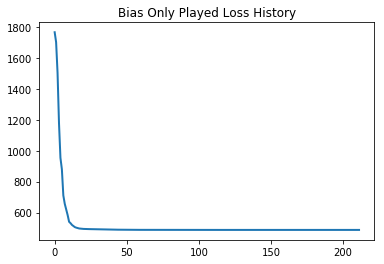

In [51]:
graph(loss_history, 'Bias Only Played Loss History')

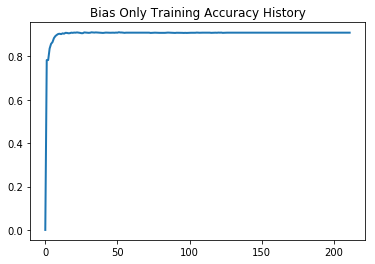

In [52]:
graph(train_accuracy_history, 'Bias Only Training Accuracy History')

In [53]:
predictions, labels = generate_outputs(played_test_data, binary_played_label)

In [54]:
accuracy(predictions, labels)

0.5766967438211064

In [55]:
np.save('./data/bias_only_played_itemBiases', itemBiases)
np.save('./data/bias_only_played_loss', loss_history)
np.save('./data/bias_only_played_train_accuracy', train_accuracy_history)

### Complete

In [56]:
loss_history = []
train_accuracy_history = []

In [67]:
complete_played_res, complete_played_f, complete_played_d = sy.optimize.fmin_l_bfgs_b(cost, 
                                [0.0]*nItems + # Initialize beta
                                [random.random() * 0.1 - 0.05 for k in range(K*(nUsers + nItems))], # Gamma
                                derivative, args=[0.001, played_train_data, played_train_labels])

In [68]:
complete_played_d

{'grad': array([ 0.00000000e+00,  1.76730285e-07,  0.00000000e+00, ...,
        -4.37533362e-09, -6.22876887e-09,  8.05804503e-09]),
 'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
 'funcalls': 307,
 'nit': 278,
 'warnflag': 0}

In [69]:
unpack(complete_played_res)

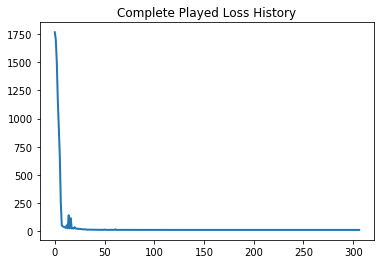

In [70]:
graph(loss_history, 'Complete Played Loss History')

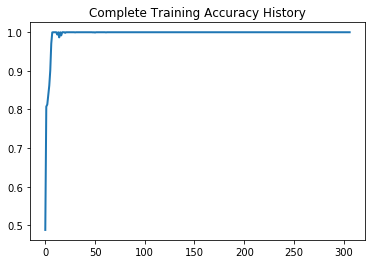

In [71]:
graph(train_accuracy_history, 'Complete Training Accuracy History')

In [72]:
predictions, labels = generate_outputs(played_test_data, binary_played_label)

In [73]:
accuracy(predictions, labels)

0.7163593566104355

In [74]:
np.save('./data/complete_played_itemGamma', itemGamma)
np.save('./data/complete_played_itemBiases', itemBiases)
np.save('./data/complete_played_userGamma', userGamma)
np.save('./data/complete_played_loss', loss_history)
np.save('./data/complete_played_train_accuracy', train_accuracy_history)